
## Time Series Analysis
<https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/>
### Modelos
<https://www.statsmodels.org/stable/index.html>
#### Previsão para 6 meses

In [1]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
import statsmodels.tsa.api as tsa
import pmdarima as pm

In [3]:
import statsmodels.tools as tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
def mape(y_test, y_pred):                                        # mean absolute percentage error
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [4]:
nome_arq = 'Dados de Emprego_IA.xlsx'
dfi = pd.read_excel(nome_arq)
dfi.head(3)

,Mês,Comercio,Alimento,Metalurgia
0,2003-01-01,322,53.5,44.2
1,2003-02-01,317,53.0,44.3
2,2003-03-01,319,53.2,44.4


In [5]:
df = dfi[['Mês', 'Metalurgia']].copy()
df.shape

(60, 2)

In [6]:
df.rename(columns= {'Mês': 'mes', 'Metalurgia': 'metal'}, inplace=True)
df.tail(3)

,mes,metal
57,2007-10-01,50.3
58,2007-11-01,49.2
59,2007-12-01,48.1


In [7]:
df.index = pd.to_datetime(df.mes, format='%Y-%m-%d')
df.head(2)

,mes,metal
mes,,
2003-01-01,2003-01-01,44.2
2003-02-01,2003-02-01,44.3


In [9]:
# previsão 6 meses
train = df.iloc[:-6].copy()   # df.loc[df.ano < 2007]
test =  df.iloc[-6:].copy()  # df.loc[df.ano == 2007]

Text(0.5, 1.0, 'Metalurgia')

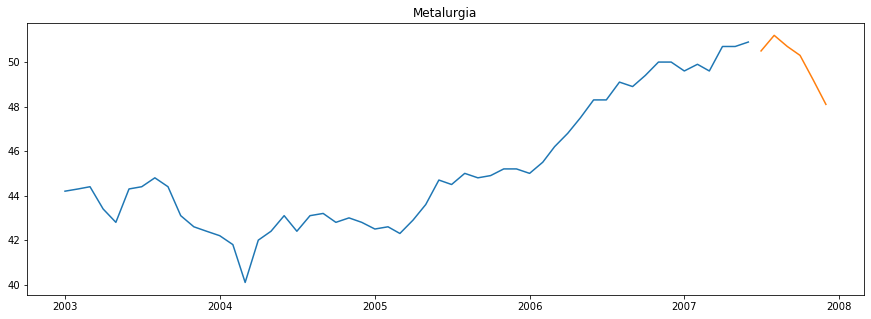

In [13]:
col_data = 'metal'
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label = 'Test')
ax.set_title('Metalurgia')

## Moving Avarage - Média Móvel

In [14]:
#y_hat_avg['pred_mm'] = train.metal.rolling(3).mean().iloc[-1]
test['pred_ma'] = train[col_data].rolling(3).mean().iloc[-1]

In [15]:
test.head()

,mes,metal,pred_ma
mes,,,
2007-07-01,2007-07-01,50.5,50.766667
2007-08-01,2007-08-01,51.2,50.766667
2007-09-01,2007-09-01,50.7,50.766667
2007-10-01,2007-10-01,50.3,50.766667
2007-11-01,2007-11-01,49.2,50.766667


In [16]:
train['ma3'] = df[col_data].rolling(3).mean()
train.tail(3)

,mes,metal,ma3
mes,,,
2007-04-01,2007-04-01,50.7,50.066667
2007-05-01,2007-05-01,50.7,50.333333
2007-06-01,2007-06-01,50.9,50.766667


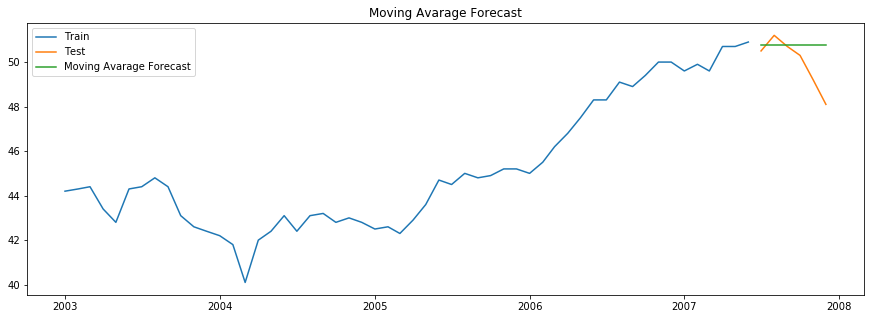

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test.pred_ma, label= 'Moving Avarage Forecast')
ax.set_title('Moving Avarage Forecast')
ax.legend(loc= 'best')

In [23]:
d = dict(MSE = tools.eval_measures.mse(test[col_data], test.pred_ma, axis=0), MAPE= mape(test[col_data], test['pred_ma']))
cresults = pd.DataFrame(data= d, index= ['moving avarage'])
cresults

,MSE,MAPE
moving avarage,1.674444,1.860326


## Simple Exponential Smoothing - suavização exponecial simples 
<https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/.

In [58]:
#pip install --upgrade pip
#pip install -U statsmodels
# smoothing level (alfa) = 0 (avarage method)
# smoothing  level = 1 (last observation = Naive method)

In [27]:
col_pred1 = 'SES1'
fit1 = SimpleExpSmoothing(np.asarray(train[col_data])).fit(smoothing_level=0.2,optimized=False)
test[col_pred1] = fit1.forecast(len(test))
d = dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0),
        MAPE= mape(test[col_data], test[col_pred1]),
        AIC= fit1.aic)
results= pd.DataFrame(data= d, index=[col_pred1])

In [28]:
col_pred2 = 'SES2'
fit2 = SimpleExpSmoothing(np.asarray(train[col_data])).fit(smoothing_level=0.6,optimized=False)
test[col_pred2] = fit2.forecast(len(test))
results.loc[col_pred2] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0), 
                                    mape(test[col_data], test[col_pred2]),
                                   fit1.aic], 
                                   ['MSE', 'MAPE', 'AIC'])

In [29]:
col_pred3= 'SES3'
fit3 = SimpleExpSmoothing(np.asarray(train[col_data])).fit(optimized=True)
test[col_pred3] = fit3.forecast(len(test))
results.loc[col_pred3] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred3], axis=0), 
                                    mape(test[col_data], test[col_pred3]),
                                   fit1.aic], 
                                   ['MSE', 'MAPE', 'AIC'])
results

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,MSE,MAPE,AIC
SES1,1.088592,1.842169,25.45855
SES2,1.657147,1.844984,25.45855
SES3,1.896667,2.040305,25.45855


In [31]:
print(fit1.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                   54
Model:             SimpleExpSmoothing   SSE                             80.348
Optimized:                      False   AIC                             25.459
Trend:                           None   BIC                             29.437
Seasonal:                        None   AICC                            26.275
Seasonal Periods:                None   Date:                 Sun, 26 Apr 2020
Box-Cox:                        False   Time:                         09:16:29
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level              44.200000                

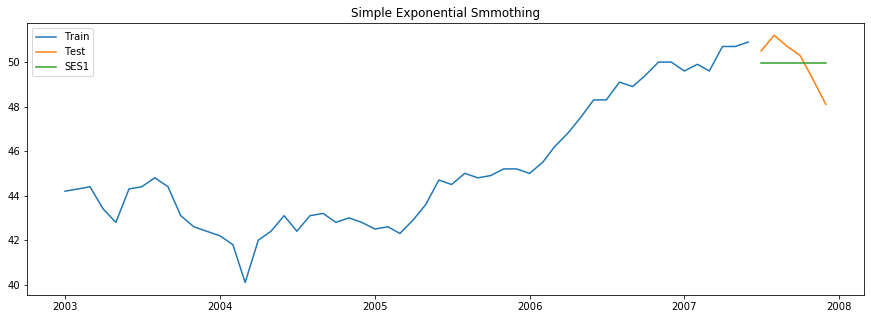

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred1], label= col_pred1)
ax.set_title('Simple Exponential Smmothing')
ax.legend(loc= 'best')

In [32]:
cresults.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), 
                                    mape(test[col_data], test[col_pred1])], 
                                   ['MSE', 'MAPE'])
cresults

,MSE,MAPE
moving avarage,1.674444,1.860326
SES1,1.088592,1.842169


## Holt's Linear Trend method - Holt com tendência - Suavização Exponencial Dupla
<https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/> <br>
<https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1> <br>
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html>

In [65]:
#from statsmodels.tsa.api import Holt

- smoothing level (alfa) = 0 (avarage method)
- smoothing  level = 1 (last observation = Naive method)
- test optimized / 0.2 / 0.8
- smoothing_slope: trend smoothing parameter: For long-term forecast, forecasting with Holt’s method will increase or decrease indefinitely into the future
- damped: trend method which has a damping parameter 0< ϕ <1 to prevent the forecast “go wild”.

In [51]:
col_pred1 = 'Holt1'
modfit1 = Holt(np.asarray(train[col_data])).fit(optimized=True)
test[col_pred1] = modfit1.forecast(len(test))
d= dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0),
       MAPE= mape(test[col_data], test[col_pred1]),
       AIC= modfit1.aic)
results= pd.DataFrame(data=d, index= [col_pred1])

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [52]:
col_pred2 = 'Holt2'
modfit2 = Holt(np.asarray(train[col_data])).fit(smoothing_level = 0.8, smoothing_slope = 0.1)
test[col_pred2] = modfit2.forecast(len(test))
results.loc[col_pred2]= pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0),
                                  mape(test[col_data], test[col_pred2]),
                                  modfit2.aic],
                                 ['MSE', 'MAPE', 'AIC'])
#results.loc['Holt2'] = pd.Series([tools.eval_measures.mse(test.metal, test.Holt2, axis=0), modfit2.aic], ['MSE', 'aic'])

In [53]:
col_pred3= 'Holt3'
modfit3 = Holt(np.asarray(train[col_data])).fit(smoothing_level = 0.2, smoothing_slope = 0.1)
test[col_pred3] = modfit3.forecast(len(test))
results.loc[col_pred3]= pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred3], axis=0),
                                  mape(test[col_data], test[col_pred3]),
                                  modfit3.aic],
                                 ['MSE', 'MAPE', 'AIC'])
#results.loc['Holt3'] = pd.Series([tools.eval_measures.mse(test.metal, test.Holt3, axis=0), modfit3.aic], ['MSE', 'aic'])

In [54]:
col_pred4= 'Holt4'
modfit4 = Holt(np.asarray(train[col_data]), exponential= True).fit(smoothing_level = 0.8, smoothing_slope = 0.1)
test[col_pred4] = modfit4.forecast(len(test))
results.loc[col_pred4]= pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred4], axis=0),
                                  mape(test[col_data], test[col_pred4]),
                                  modfit4.aic],
                                 ['MSE', 'MAPE', 'AIC'])
#results.loc['Holt4'] = pd.Series([tools.eval_measures.mse(test.metal, test.Holt4, axis=0), modfit4.aic], ['MSE', 'aic'])

In [55]:
col_pred5= 'Holt5'
modfit5 = Holt(np.asarray(train[col_data]), damped= True).fit(smoothing_level = 0.8, smoothing_slope = 0.1)
test[col_pred5] = modfit5.forecast(len(test))
results.loc[col_pred5]= pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred5], axis=0),
                                  mape(test[col_data], test[col_pred5]),
                                  modfit5.aic],
                                 ['MSE', 'MAPE', 'AIC'])
#results.loc['Holt5'] = pd.Series([tools.eval_measures.mse(test.metal, test.Holt5, axis=0), modfit5.aic], ['MSE', 'aic'])
results

,MSE,MAPE,AIC
Holt1,3.318038,2.766334,-41.762318
Holt2,5.259479,3.649975,-39.636255
Holt3,7.347389,4.570976,2.171113
Holt4,5.584062,3.779930,-39.972671
Holt5,3.694916,2.950687,-37.976795


In [56]:
modfit1.summary()

Dep. Variable:,endog,No. Observations:,54
Model:,Holt,SSE,21.487
Optimized:,True,AIC,-41.762
Trend:,Additive,BIC,-33.806
Seasonal:,None,AICC,-39.975
Seasonal Periods:,None,Date:,"Sun, 26 Apr 2020"
Box-Cox:,False,Time:,10:26:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9747111,alpha,True
smoothing_slope,0.000000,beta,True


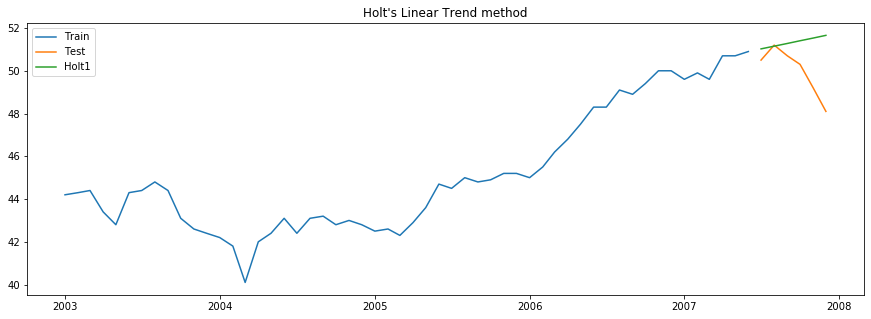

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred1], label= col_pred1)
ax.set_title("Holt's Linear Trend method")
ax.legend(loc= 'best')

In [58]:
cresults.loc[col_pred1] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0), 
                                    mape(test[col_data], test[col_pred1])], 
                                   ['MSE', 'MAPE'])

## [ARIMA: Autoregressive Integrated Moving Average](https://towardsdatascience.com/implementing-time-series-arima-38fd77fc1d79)

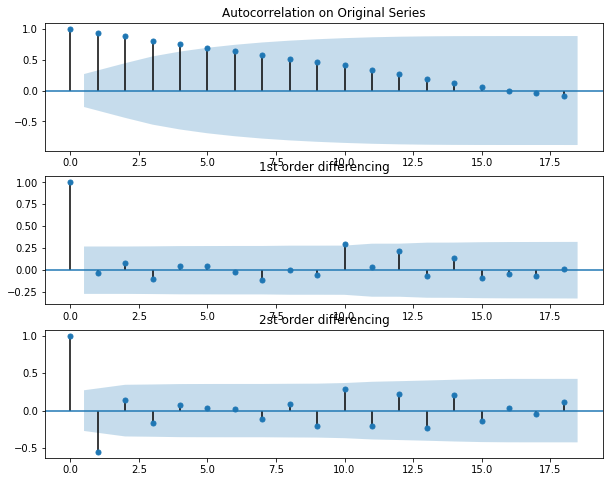

In [40]:
# order of differencing, d, using auto correlation
col_data = 'metal' # train column
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize= (10,8))
fig= plot_acf(train[col_data], ax= ax0, title= 'Autocorrelation on Original Series')   # series.squeeze()
fig= plot_acf(train[col_data].diff().dropna(), ax= ax1, title= '1st order differencing')
fig= plot_acf(train[col_data].diff().diff().dropna(), ax= ax2, title= '2st order differencing')
# q= lag significativa na diferenciação que leva a uma série estacionária

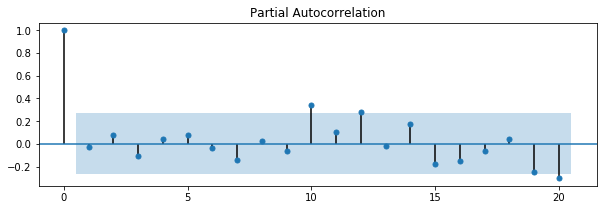

In [41]:
# order of AR, p, using partial autocorrelation  # d obtido na celula acima
fig, ax1 = plt.subplots(figsize=(10,3))
#fig = plot_pacf(train[col_data], ax= ax1, lags= 20)
fig = plot_pacf(train[col_data].diff().dropna(), ax= ax1, lags= 20)          # d= 1
#fig = plot_pacf(train[col_data].diff().diff().dropna(), ax= ax1, lags= 20)

### Py auto.arima - pmdarima
<https://github.com/alkaline-ml/pmdarima>

In [42]:
pm_model = pm.auto_arima(train[col_data], d=1, start_p=0, start_q=0, max_p=20, max_q=12, test='adf', seasonal= False, 
                         error_action= 'ignore', suppress_warnings= True, stepwise=True)
pm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -51.298
Date:                Sun, 26 Apr 2020   AIC                            106.596
Time:                        09:58:48   BIC                            110.537
Sample:                             0   HQIC                           108.112
                                 - 54                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1264      0.088      1.444      0.149      -0.045       0.298
sigma2         0.4057      0.065      6.278      0.000       0.279       0.532
===================================================================================
Ljung-Box (Q):                       38.17   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.55   Prob(JB):                         0.35
Heteroskedasticity (H):               0.28   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
col_datetime = 'mes'
startdate = '2007-07-01'
enddate= '2007-12-01'
col_pred1= 'ARIMA 010'
modfit1 = tsa.ARIMA(train[col_data], dates=np.asarray(train[col_datetime]), order=(0, 1, 0)).fit()
test[col_pred1] = modfit1.predict(start= startdate, end= enddate, dynamic=True)
d = dict(MSE= tools.eval_measures.mse(test[col_data], test[col_pred1], axis=0),
        MAPE= mape(test[col_data], test[col_pred1]),
        AIC= fit1.aic)
results= pd.DataFrame(data= d, index=[col_pred1])
results

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,MSE,MAPE,AIC
ARIMA 010,2488.461138,99.747058,25.45855


In [45]:
# paramentros para d= 0
pm_model = pm.auto_arima(train[col_data], d=0, start_p=0, start_q=0, max_p=20, max_q=12, test='adf', seasonal= False, 
                         error_action= 'ignore', suppress_warnings= True, stepwise=True)
pm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -54.716
Date:                Sun, 26 Apr 2020   AIC                            115.431
Time:                        10:11:59   BIC                            121.398
Sample:                             0   HQIC                           117.732
                                 - 54                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8747      1.030      0.849      0.396      -1.143       2.893
ar.L1          0.9813      0.022     43.821      0.000       0.937       1.025
sigma2         0.4180      0.069      6.029      0.000       0.282       0.554
===================================================================================
Ljung-Box (Q):                       46.28   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.23   Prob(JB):                         0.44
Heteroskedasticity (H):               0.40   Skew:                            -0.12
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
col_pred2= 'ARIMA 100'
modfit2 = tsa.ARIMA(train[col_data], dates=np.asarray(train[col_datetime]), order=(1, 0, 0)).fit()
test[col_pred2] = modfit2.predict(start= startdate, end= enddate, dynamic=True)
results.loc[col_pred2] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0),
                                   mape(test[col_data], test[col_pred2]),
                                   modfit2.aic],
                                  ['MSE', 'MAPE', 'AIC'])
results

c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\marce\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


,MSE,MAPE,AIC
ARIMA 010,2488.461138,99.747058,25.458550
ARIMA 100,1.281366,1.626056,115.431208


In [47]:
print(modfit2.summary())

                              ARMA Model Results                              
Dep. Variable:                  metal   No. Observations:                   54
Model:                     ARMA(1, 0)   Log Likelihood                 -54.716
Method:                       css-mle   S.D. of innovations              0.647
Date:                Sun, 26 Apr 2020   AIC                            115.431
Time:                        10:19:57   BIC                            121.398
Sample:                    01-01-2003   HQIC                           117.732
                         - 06-01-2007                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          46.7363      2.796     16.714      0.000      41.256      52.217
ar.L1.metal     0.9812      0.020     50.036      0.000       0.943       1.020
                                    Roots       

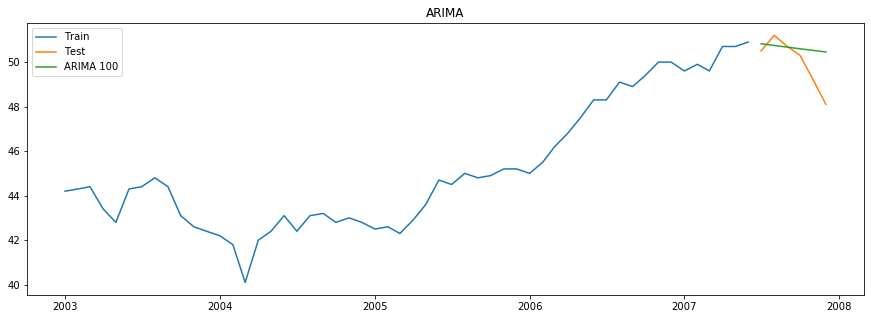

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train[col_data], label= 'Train')
ax.plot(test[col_data], label= 'Test')
ax.plot(test[col_pred2], label= col_pred2)
ax.set_title('ARIMA')
ax.legend(loc= 'best')

In [49]:
cresults.loc[col_pred2] = pd.Series([tools.eval_measures.mse(test[col_data], test[col_pred2], axis=0), 
                                    mape(test[col_data], test[col_pred2])], 
                                   ['MSE', 'MAPE'])

## Comparativo dos Modelos

In [59]:
cresults

,MSE,MAPE
moving avarage,1.674444,1.860326
SES1,1.088592,1.842169
ARIMA 100,1.281366,1.626056
Holt1,3.318038,2.766334


### Suavisação Exponencial Simples teve o menor erro
### ARIMA mostrou com mais clareza a tendência de invesão e baixa da série